In [1]:
from google.colab import drive
drive.mount("/files", force_remount=True)

Mounted at /files


In [113]:
import pandas as pd
import numpy as np

# Load file from GoogleDrive
csv_file = None
with open("/files/My Drive/Mark Johnston Master's Project/CPSC121data.csv", "r") as file:
  csv_file = pd.read_csv(file)


# Convert batch names to numbers
#batch_names = csv_file.Batch.unique()
#csv_file['Batch Index'] = csv_file.apply(lambda x: np.where(batch_names==x.Batch)[0][0], axis=1)

#strip % signs off
csv_file.iloc[:, 0:31] = csv_file.iloc[:,0:31].apply(lambda x: x.str.rstrip('%')).apply(pd.to_numeric, errors='coerce')

#convert all NaN to 0
csv_file.fillna(0, inplace=True)

csv_file['Final Letter Grade'].replace(['A', 'B', 'C', 'D', 'F'], [0, 1, 2, 3, 4], inplace = True)


In [3]:
csv_file

,Quiz 1,Quiz 2,Quiz 3,Quiz 4,Quiz 5,Quiz 6,Quiz 7,Quiz 8,Quiz 9,Quiz 10,Quiz 11,Quiz 12,Lab 1,Lab 2,Lab 3,Lab 4,Lab 5,Lab 6,Lab 7,Lab 8,Lab 9,Lab 10,Lab 11,Lab 12,Lab 13,Project 1,Project 2,Project 3,Midterm,Final Exam,Final Grade,Final Letter Grade
0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,3.26,0.69,4
1,72.22,54.40,28.57,64.29,30.0,59.38,47.22,30.77,50.00,50.00,52.38,24.00,100.0,100.0,97.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,49.0,0.0,21.26,24.13,27.59,4
2,100.00,100.00,50.00,42.86,55.0,75.00,55.56,69.23,66.67,41.67,71.43,50.00,100.0,100.0,94.5,100.0,98.5,85.0,60.0,0.0,60.0,98.5,80.0,60.0,60.0,90.0,56.0,54.0,52.21,50.46,65.96,3
3,69.44,80.77,57.14,35.71,80.0,90.63,27.78,15.38,56.67,41.67,38.10,43.33,100.0,100.0,100.0,100.0,98.5,100.0,0.0,60.0,100.0,97.0,100.0,100.0,100.0,100.0,100.0,90.0,62.07,46.87,71.20,2
4,100.00,85.71,64.29,50.00,77.5,91.25,100.00,42.31,66.67,77.78,57.14,54.44,100.0,98.5,100.0,93.0,97.0,85.0,60.0,0.0,100.0,95.0,60.0,0.0,0.0,90.0,54.0,100.0,59.66,73.15,68.30,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,100.00,100.00,75.00,100.00,87.5,85.71,100.00,100.00,42.86,0.00,100.00,100.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,60.0,100.0,100.0,100.0,100.0,104.00,89.46,97.46,0
210,100.00,0.00,75.00,82.35,100.0,78.57,0.00,0.00,28.57,75.00,100.00,0.00,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,100.0,100.0,100.0,80.0,0.0,0.0,0.0,0.0,97.00,0.00,55.34,4
211,91.67,100.00,75.00,82.35,87.5,100.00,100.00,100.00,78.57,93.33,100.00,76.92,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,98.0,95.0,100.0,99.67,98.44,101.82,0
212,77.78,85.71,75.00,58.82,62.5,78.57,77.78,50.00,42.86,83.33,50.00,100.00,100.0,80.0,100.0,50.0,75.0,55.0,50.0,80.0,80.0,60.0,100.0,35.0,80.0,78.0,37.0,40.0,66.67,85.15,75.12,2


# We will use Batch Cross Validation to ensure that the model is able to predict data from totally unknown student population

We can use GroupShuffleSPlit to implement Batch Cross Validation https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html#sklearn.model_selection.GroupShuffleSplit

#Setting data up

In [114]:
import random

pd.set_option('display.max_rows', 100)

#split into cross-validation, development and test sets
test = csv_file.sample(frac = .1, random_state=1)

temp = csv_file[~csv_file.isin(test)]
temp = temp.dropna()

dev = temp.sample(frac = .3, random_state=1)

cval = temp[~temp.isin(dev)]
cval = cval.dropna()

print(test.shape)
print(dev.shape)
print(cval.shape)


(21, 32)
(58, 32)
(135, 32)


#Choosing which columns I want to use

Listing out all possible columns to easily swap between them:

'Quiz 1', 'Quiz 2', 'Quiz 3', 'Quiz 4', 'Quiz 5', 'Quiz 6', 'Quiz 7', 'Quiz 8', 'Quiz 9', 'Quiz 10', 'Quiz 11'

'Lab 1', 'Lab 2', 'Lab 3', 'Lab 4', 'Lab 5', 'Lab 6', 'Lab 7', 'Lab 8', 'Lab 9', 'Lab 10', 'Lab 11', 'Lab 12', 'Lab 13'

'Project 1', 'Project 2', 'Project 3', 

'Midterm', 'Final Exam', 'Final Grade'

In [115]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

grade_data_cval = cval[['Quiz 1', 'Quiz 2', 'Quiz 3', 'Quiz 4', 'Quiz 5', 'Quiz 6', 'Quiz 7', 'Quiz 8', 'Lab 1', 'Lab 2', 'Lab 3', 'Lab 4', 'Lab 5', 'Lab 6', 'Lab 7', 'Project 1', 'Project 2', 'Project 3','Midterm' ]]
final_grade_data_cval = cval['Final Grade']

grade_data_dev = dev[['Quiz 1', 'Quiz 2', 'Quiz 3', 'Quiz 4', 'Quiz 5', 'Quiz 6', 'Quiz 7', 'Quiz 8', 'Lab 1', 'Lab 2', 'Lab 3', 'Lab 4', 'Lab 5', 'Lab 6', 'Lab 7', 'Project 1', 'Project 2', 'Project 3', 'Midterm']]
final_grade_data_dev = dev['Final Grade']


# Testing Linear Regression with Cross Validation


LR r^2: 0.76 (95% CI +/- 0.27)


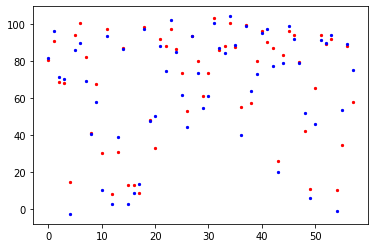


Coefficients: 
 [-0.03248114  0.05855778  0.0056966   0.03149935 -0.07964622  0.11977032
  0.05422781  0.09088696  0.0586145   0.0406807  -0.01758842  0.01320524
  0.08116385  0.07829578  0.06793063  0.07012422  0.07152589  0.08526719
  0.30682169]


In [116]:
#display(cval, dev, test)
from sklearn import linear_model

#Cross-val for linear regression
clf = linear_model.LinearRegression()
scores = cross_val_score(clf, grade_data_cval.fillna(0), final_grade_data_cval.fillna(0), cv=10, scoring = 'r2')
print("LR r^2: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Test on the development set
regr = linear_model.LinearRegression()
regr.fit(grade_data_cval.fillna(0), final_grade_data_cval.fillna(0))
pred = regr.predict(grade_data_dev.fillna(0))

plt.scatter(range(len(grade_data_dev)), final_grade_data_dev.fillna(0), color = "red", s=5)
plt.scatter(range(len(grade_data_dev)), pred, color = "blue", s=5)
plt.show()

print('\nCoefficients: \n', regr.coef_)
# The mean squared error
#print('Root mean squared error: %.2f'
      #% sqrt(mean_squared_error(midterm_grade_data_val.fillna(0), pred)))
# The coefficient of determination: 1 is perfect prediction
#print('Coefficient of determination: %.2f'
      #% r2_score(midterm_grade_data_val.fillna(0), pred))
comparison = pd.DataFrame({'Actual':final_grade_data_dev.fillna(0), 'Predicted':pred})
#print("\nComparison of predicted scores vs actual scores on development set:")
#display(comparison)


#Error between predictions and actual scores

In [117]:
diff = []
index = []
for i in range(comparison.shape[0]):
  #print("Difference: ", abs(comparison.iloc[i][0] - comparison.iloc[i][1]), "   index: ", comparison.index[i])
  diff.append(abs(comparison.iloc[i][0] - comparison.iloc[i][1]))
  index.append(comparison.index[i] + 2)

diff_df = pd.DataFrame({"Actual" : comparison['Actual'], "Predicted" : comparison['Predicted'], "Difference" : diff, "Index" : index})
#display(diff_df)

diff_df.sort_values(by = ['Difference'])

,Actual,Predicted,Difference,Index
20,99.42,99.137337,0.282663,22
196,48.06,47.762746,0.297254,198
91,93.82,93.495017,0.324983,93
125,87.08,86.720756,0.359244,127
67,79.56,79.099091,0.460909,69
82,88.48,89.073696,0.593696,84
127,41.09,40.447852,0.642148,129
6,89.09,89.791558,0.701558,8
15,87.76,88.605924,0.845924,17
34,98.61,97.697590,0.912410,36


In [118]:
avg_error = np.average(diff_df['Difference'])
print('Avg error = ', avg_error)

std_dev = np.std(diff_df['Difference'])
print('Std dev = ', std_dev)

Avg error =  6.517220353756361
Std dev =  5.6408965820482955


#Working with the coefficients of the linear regression

My idea here is to see which quiz/labs (and therefore topics) affect the course "the most."

In [110]:
avg_score = []
for i in range(0,len(grade_data_cval.columns)):
  avg = np.average(grade_data_cval.iloc[:,i])
  avg_score.append(avg)

topics = pd.DataFrame({'Topic' : grade_data_cval.columns, 'Average Score' : avg_score, 'Coefficient' : regr.coef_})

topics

,Topic,Average Score,Coefficient
0,Quiz 1,85.401926,-0.003576
1,Quiz 2,84.926593,0.050528
2,Quiz 3,64.149407,0.033734
3,Quiz 4,67.587704,0.016737
4,Quiz 5,69.779704,0.053266
5,Quiz 6,70.418222,0.080720
6,Quiz 7,72.710148,0.048753
7,Quiz 8,56.424370,0.026145
8,Quiz 9,55.706963,0.072205
9,Quiz 10,63.234222,0.055415


#Order based on average score

In [111]:
topics.sort_values(by = 'Average Score')

,Topic,Average Score,Coefficient
23,Lab 13,47.674074,0.065467
8,Quiz 9,55.706963,0.072205
18,Lab 8,56.325926,0.066521
7,Quiz 8,56.424370,0.026145
22,Lab 12,58.488889,0.034175
10,Quiz 11,60.352296,0.063586
17,Lab 7,61.729630,0.018908
9,Quiz 10,63.234222,0.055415
2,Quiz 3,64.149407,0.033734
3,Quiz 4,67.587704,0.016737


#Order based on coefficient

In [112]:
topics.sort_values(by = 'Coefficient')

,Topic,Average Score,Coefficient
13,Lab 3,92.225926,-0.029933
11,Lab 1,97.777778,-0.023928
0,Quiz 1,85.401926,-0.003576
15,Lab 5,87.851852,0.012989
3,Quiz 4,67.587704,0.016737
17,Lab 7,61.729630,0.018908
19,Lab 9,78.696296,0.023014
16,Lab 6,75.122222,0.024466
7,Quiz 8,56.424370,0.026145
2,Quiz 3,64.149407,0.033734


#Testing Kernal Ridge Regression with Cross Validaiton

KR r^2: 0.76 (95% CI +/- 0.29)


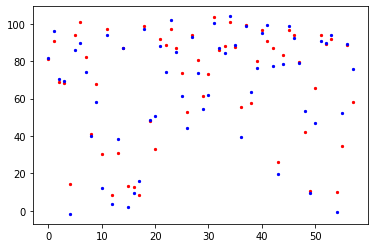


Coefficients: 
 [  0.69        -0.26632485  -2.17132975   2.36355373   2.2752101
 -10.61171855  -3.30080617 -10.02764608   3.92796726  -4.02520491
   6.33928642   7.62721228  -6.44156074  -2.40709018  -5.65976968
 -20.88841971  -3.07839958 -17.90824272 -18.7048782    5.75557167
   1.2343592   -3.88293951 -11.57873463  14.52975504   6.17762901
  -9.07657662  10.17248178   2.80334889 -12.79241701   5.740059
   3.16999035   8.34487592  -1.10254893   2.75144891   2.9473347
  -1.64435985 -10.5520617   -1.54756517   1.40556192   7.42432804
  -6.21852797   2.19350388   6.59345694   3.29689131  -3.19257327
  -2.63940144   3.88025828  -8.4912911   -7.20256123  11.99807928
  -2.76325023  -5.94463576 -20.94425193   1.65471243  -0.07293564
   5.34361504   2.0619591   -4.58716544  -3.35419099   2.65327767
  -8.93278561  -3.878982    -0.1029764    1.20713781   2.09294568
 -13.02888166   2.19258908  -9.68551399   3.4537192   -2.66250628
   3.63671854   9.3941293   -5.45717486   4.89197422   0.129699

In [119]:
from sklearn.kernel_ridge import KernelRidge

#Cross-val for Kernal Ridge Regression
clf = KernelRidge()
scores = cross_val_score(clf, grade_data_cval.fillna(0), final_grade_data_cval.fillna(0), cv=10, scoring = 'r2')
print("KR r^2: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Test on the development set
regr = KernelRidge()
regr.fit(grade_data_cval.fillna(0), final_grade_data_cval.fillna(0))
pred = regr.predict(grade_data_dev.fillna(0))

plt.scatter(range(len(grade_data_dev)), final_grade_data_dev.fillna(0), color = "red", s=5)
plt.scatter(range(len(grade_data_dev)), pred, color = "blue", s=5)
plt.show()

print('\nCoefficients: \n', regr.dual_coef_)

comparison = pd.DataFrame({'Actual':final_grade_data_dev.fillna(0), 'Predicted':pred})

#Error between predictions and actual scores

In [120]:
diff = []
index = []
for i in range(comparison.shape[0]):
  #print("Difference: ", abs(comparison.iloc[i][0] - comparison.iloc[i][1]), "   index: ", comparison.index[i])
  diff.append(abs(comparison.iloc[i][0] - comparison.iloc[i][1]))
  index.append(comparison.index[i] + 2)

diff_df = pd.DataFrame({"Actual" : comparison['Actual'], "Predicted" : comparison['Predicted'], "Difference" : diff, "Index" : index})
#display(diff_df)

diff_df.sort_values(by = ['Difference'])

,Actual,Predicted,Difference,Index
125,87.08,87.267210,0.187210,127
67,79.56,79.285808,0.274192,69
196,48.06,48.414440,0.354440,198
20,99.42,98.941313,0.478687,22
82,88.48,89.045217,0.565217,84
91,93.82,93.114589,0.705411,93
6,89.09,89.908385,0.818385,8
50,80.91,81.773172,0.863172,52
15,87.76,88.674689,0.914689,17
129,10.60,9.509250,1.090750,131


In [121]:
avg_error = np.average(diff_df['Difference'])
print('Avg error = ', avg_error)

std_dev = np.std(diff_df['Difference'])
print('Std dev = ', std_dev)

Avg error =  6.315278993264194
Std dev =  5.519781837752311


#Testing Gaussian Process Regression with Cross Validation

GP r^2: 0.76 (95% CI +/- 0.28)


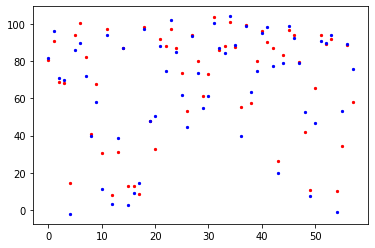


Coefficients: 
 [ 0.06327395  0.00172097 -0.03228917  0.03109532  0.02508131 -0.13717809
 -0.04193834 -0.13364622  0.05065984 -0.05268854  0.08132419  0.10132712
 -0.07761381 -0.03468942 -0.06058962 -0.27060421 -0.03845952 -0.23105742
 -0.21570593  0.0738868   0.01594677 -0.05319571 -0.15261946  0.19305224
  0.08053483 -0.11480739  0.13146907  0.03554533 -0.17376809  0.07648336
  0.04049989  0.10848483 -0.01401808  0.03887742  0.03755918 -0.02252615
 -0.13579586 -0.02134845  0.0172076   0.09618225 -0.09210749  0.02613755
  0.08286096  0.04163104 -0.04334852 -0.0372577   0.04929347 -0.10942616
 -0.09264673  0.16217353 -0.03784457 -0.07636595 -0.26566111  0.02342606
 -0.00308159  0.07001617  0.02491558 -0.06274968 -0.04362032  0.02975705
 -0.11654919 -0.05139916 -0.00254638  0.03692091  0.02557755 -0.16819987
  0.02676321 -0.13244266  0.04524271 -0.03837503  0.04838622  0.11962821
 -0.07003646  0.06445142 -0.00128118  0.06761569 -0.12714923 -0.22740667
  0.00167371 -0.0768201   0.171132

In [122]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

#Cross-val for Gaussian Processs Regression
kernel = DotProduct() + WhiteKernel()
clf = GaussianProcessRegressor(kernel=kernel, random_state=0)
scores = cross_val_score(clf, grade_data_cval.fillna(0), final_grade_data_cval.fillna(0), cv=10, scoring = 'r2')
print("GP r^2: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Test on the development set
regr = GaussianProcessRegressor(kernel=kernel, random_state=0)
regr.fit(grade_data_cval.fillna(0), final_grade_data_cval.fillna(0))
pred = regr.predict(grade_data_dev.fillna(0))

plt.scatter(range(len(grade_data_dev)), final_grade_data_dev.fillna(0), color = "red", s=5)
plt.scatter(range(len(grade_data_dev)), pred, color = "blue", s=5)
plt.show()

print('\nCoefficients: \n', regr.alpha_)

comparison = pd.DataFrame({'Actual':final_grade_data_dev.fillna(0), 'Predicted':pred})

#Error between predictions and actual scores

In [123]:
diff = []
index = []
for i in range(comparison.shape[0]):
  #print("Difference: ", abs(comparison.iloc[i][0] - comparison.iloc[i][1]), "   index: ", comparison.index[i])
  diff.append(abs(comparison.iloc[i][0] - comparison.iloc[i][1]))
  index.append(comparison.index[i] + 2)

diff_df = pd.DataFrame({"Actual" : comparison['Actual'], "Predicted" : comparison['Predicted'], "Difference" : diff, "Index" : index})
#display(diff_df)

diff_df.sort_values(by = ['Difference'])

,Actual,Predicted,Difference,Index
196,48.06,48.102484,0.042484,198
125,87.08,87.006036,0.073964,127
67,79.56,79.194829,0.365171,69
20,99.42,99.034200,0.385800,22
91,93.82,93.308841,0.511159,93
82,88.48,89.048745,0.568745,84
6,89.09,89.861999,0.771999,8
15,87.76,88.653814,0.893814,17
50,80.91,81.847982,0.937982,52
127,41.09,40.071393,1.018607,129


In [124]:
avg_error = np.average(diff_df['Difference'])
print('Avg error = ', avg_error)

std_dev = np.std(diff_df['Difference'])
print('Std dev = ', std_dev)

Avg error =  6.398812761933817
Std dev =  5.5539950245578344


# Run regressors to predict midterm grades and evaluate using cross validation
Used this during my initial run to determine which regressions were the best

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn import linear_model

from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn import neighbors

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

from sklearn import tree

from sklearn.neural_network import MLPRegressor

#cv = GroupShuffleSplit(n_splits=20, train_size=.75)

# Linear regression
clf = linear_model.LinearRegression()
scores = cross_val_score(clf, grade_data_cval.fillna(0), final_grade_data_cval.fillna(0), cv=10, scoring = 'r2')
print("LR r^2: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Support vector regression
clf = svm.SVR()
scores = cross_val_score(clf, grade_data_cval.fillna(0), final_grade_data_cval.fillna(0), cv=10, scoring = 'r2')
print("SVR r^2: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Kernel ridge regression
clf = KernelRidge()
scores = cross_val_score(clf, grade_data_cval.fillna(0), final_grade_data_cval.fillna(0), cv=10, scoring = 'r2')
print("KR r^2: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Nearest neighbor regression
clf = neighbors.KNeighborsRegressor(5)
scores = cross_val_score(clf, grade_data_cval.fillna(0), final_grade_data_cval.fillna(0), cv=10, scoring = 'r2')
print("NearestN r^2: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Gaussian Process regression
kernel = DotProduct() + WhiteKernel()
clf = GaussianProcessRegressor(kernel=kernel, random_state=0)
scores = cross_val_score(clf, grade_data_cval.fillna(0), final_grade_data_cval.fillna(0), cv=10, scoring = 'r2')
print("GP r^2: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 2))

# MLP regression
clf = MLPRegressor(hidden_layer_sizes=(50, 50), learning_rate_init=0.01, early_stopping=True)
scores = cross_val_score(clf, grade_data_cval.fillna(0), final_grade_data_cval.fillna(0), cv=10, scoring = 'r2')
print("MLP r^2: %0.2f (95%% CI +/- %0.2f)" % (scores.mean(), scores.std() * 2))


LR r^2: 0.76 (95% CI +/- 0.27)
SVR r^2: 0.37 (95% CI +/- 0.42)
KR r^2: 0.76 (95% CI +/- 0.29)
NearestN r^2: 0.72 (95% CI +/- 0.21)
GP r^2: 0.76 (95% CI +/- 0.28)
MLP r^2: 0.72 (95% CI +/- 0.18)


#Graphing the Different Weeks of Assignments

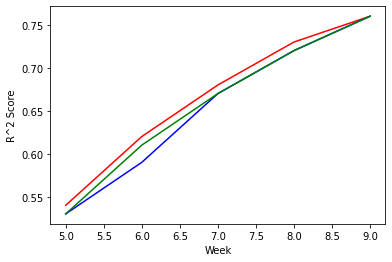

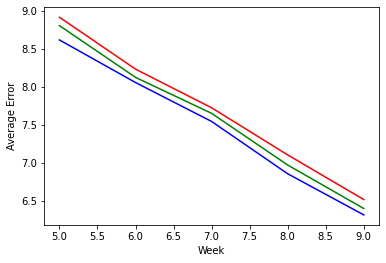

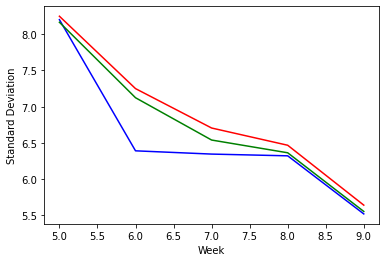

In [30]:
lin_scores = [.54, .62, .68, .73, .76]
kernel_scores = [.53, .59, .67, .72, .76]
gaussian_scores = [.53, .61, .67, .72, .76]

lin_avg = [8.919, 8.235, 7.726, 7.105, 6.517]
kernel_avg = [8.620, 8.059, 7.546, 6.857, 6.315]
gaussian_avg = [8.809, 8.127, 7.653, 6.972, 6.399]

lin_std = [8.249, 7.25, 6.706, 6.468, 5.641]
kernel_std = [8.202, 6.391, 6.346, 6.322, 5.520]
gaussian_std = [8.166, 7.124, 6.54, 6.364, 5.554]

x_axis = [5, 6, 7, 8, 9]


plt.plot(x_axis, lin_scores, 'red', x_axis, kernel_scores, 'blue', x_axis, gaussian_scores, 'green')
plt.ylabel('R^2 Score')
plt.xlabel('Week')
plt.show()

plt.plot(x_axis, lin_avg, 'red', x_axis, kernel_avg, 'blue', x_axis, gaussian_avg, 'green')
plt.ylabel('Average Error')
plt.xlabel('Week')
plt.show()

plt.plot(x_axis, lin_std, 'red', x_axis, kernel_std, 'blue', x_axis, gaussian_std, 'green')
plt.ylabel('Standard Deviation')
plt.xlabel('Week')
plt.show()

#Using letter grades to change it into a classificaiton problem instead of a regression

In [90]:
import tensorflow as tf

NN_grade_data_cval = cval[['Quiz 1', 'Quiz 2', 'Quiz 3', 'Quiz 4', 'Quiz 5', 'Quiz 6', 'Quiz 7', 'Quiz 8', 'Lab 1', 'Lab 2', 'Lab 3', 'Lab 4', 'Lab 5', 'Lab 6', 'Lab 7', 'Project 1', 'Project 2', 'Project 3', 'Midterm']]
NN_final_grade_data_cval = cval['Final Letter Grade']

NN_grade_data_dev = dev[['Quiz 1', 'Quiz 2', 'Quiz 3', 'Quiz 4', 'Quiz 5', 'Quiz 6', 'Quiz 7', 'Quiz 8', 'Lab 1', 'Lab 2', 'Lab 3', 'Lab 4', 'Lab 5', 'Lab 6', 'Lab 7', 'Project 1', 'Project 2', 'Project 3', 'Midterm' ]]
NN_final_grade_data_dev = dev['Final Letter Grade']

NN_grade_data_cval = NN_grade_data_cval.values
NN_grade_data_dev = NN_grade_data_dev.values

NN_final_grade_data_cval = tf.keras.utils.to_categorical(NN_final_grade_data_cval, 5)
NN_final_grade_data_dev = tf.keras.utils.to_categorical(NN_final_grade_data_dev, 5)

NN_grade_data_cval /= 100
NN_grade_data_dev /= 100

#print(NN_grade_data_dev)
#print(NN_grade_data_dev.shape)


In [87]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(128, activation= 'relu', input_shape=(19,)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(256, activation= 'relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(128, activation= 'relu'),
                             tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model.fit(NN_grade_data_cval, NN_final_grade_data_cval, epochs=30)

print('\nEvaluate Model: \n')
test_loss, test_acc = model.evaluate(NN_grade_data_dev, NN_final_grade_data_dev, verbose=1)

print('\nTest accuracy:', test_acc)

NN_prediction = model.predict(NN_grade_data_dev)

#print(NN_grade_data_cval.iloc[0])
#print(NN_final_grade_data_cval)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 128)               2560      
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_71 (Dense)             (None, 5)                 645       
Total params: 69,125
Trainable params: 69,125
Non-trainable params: 0
_________________________________________________

In [ ]:
NN_prediction

#Make the newtorks predictions more clear

First choice is what it predicts most likely, Second choice is second most likely

In [88]:
first_grade = []
second_grade = []

for i in range(0,len(NN_prediction)):
  first = NN_prediction[i][0]
  first_in = 0
  second = -999
  for j in range(1,5):
    if (NN_prediction[i][j] > first):
      second = first
      second_in = first_in
      first = NN_prediction[i][j]
      first_in = j
    if (NN_prediction[i][j] > second and NN_prediction[i][j] < first):
      second = NN_prediction[i][j]
      second_in = j
  first_grade.append(first_in)
  second_grade.append(second_in)

#print(first_grade)
#print(second_grade)

grade_check = pd.DataFrame({"First Choice" : first_grade, "Second Choice" : second_grade, "Actual" : dev['Final Letter Grade']})

grade_check.replace([0, 1, 2, 3, 4], ['A', 'B', 'C', 'D', 'F'], inplace = True)
grade_check

,First Choice,Second Choice,Actual
50,B,A,B
78,A,B,A
182,C,B,D
40,C,D,D
203,F,D,F
12,A,B,A
139,A,B,A
90,B,C,B
127,F,D,F
199,F,D,D


#Find error using both first and second choice predictions

In [89]:
error_count = 0
for i in range(0, len(grade_check)):
  if (grade_check.iloc[i][0] != grade_check.iloc[i][2] and grade_check.iloc[i][1] != grade_check.iloc[i][2]):
    error_count += 1

print((1 - (error_count / len(grade_check))) * 100)

93.10344827586206


#Using a Neural Network, but as a binary classification problem

For this, I the two classifications will either be pass or fail. While a 'D' letter grade is considered passing, the goal is to identify students in danger of failing so I am going to consider A-C as passing, and D-F as failing

In [105]:
cval_bi = cval.copy()
dev_bi = dev.copy()

cval_bi['Final Letter Grade'].replace([0, 1, 2, 3, 4], [0, 0, 0, 1, 1], inplace = True)
dev_bi['Final Letter Grade'].replace([0, 1, 2, 3, 4], [0, 0, 0, 1, 1], inplace = True)

#print(cval_bi)
#print(dev_bi)

In [106]:
import tensorflow as tf

bi_grade_data_cval = cval[['Quiz 1', 'Quiz 2', 'Quiz 3', 'Quiz 4', 'Quiz 5', 'Quiz 6', 'Quiz 7', 'Quiz 8', 'Lab 1', 'Lab 2', 'Lab 3', 'Lab 4', 'Lab 5', 'Lab 6', 'Lab 7', 'Project 1', 'Project 2', 'Project 3', 'Midterm']]
bi_final_grade_data_cval = cval_bi['Final Letter Grade']

bi_grade_data_dev = dev[['Quiz 1', 'Quiz 2', 'Quiz 3', 'Quiz 4', 'Quiz 5', 'Quiz 6', 'Quiz 7', 'Quiz 8', 'Lab 1', 'Lab 2', 'Lab 3', 'Lab 4', 'Lab 5', 'Lab 6', 'Lab 7', 'Project 1', 'Project 2', 'Project 3', 'Midterm']]
bi_final_grade_data_dev = dev_bi['Final Letter Grade']

bi_grade_data_cval = bi_grade_data_cval.values
bi_grade_data_dev = bi_grade_data_dev.values

bi_final_grade_data_cval = tf.keras.utils.to_categorical(bi_final_grade_data_cval, 2)
bi_final_grade_data_dev = tf.keras.utils.to_categorical(bi_final_grade_data_dev, 2)

bi_grade_data_cval /= 100
bi_grade_data_dev /= 100

In [107]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(128, activation= 'relu', input_shape=(19,)),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(256, activation= 'relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(128, activation= 'relu'),
                             tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model.fit(bi_grade_data_cval, bi_final_grade_data_cval, epochs=30)

print('\nEvaluate Model: \n')
test_loss, test_acc = model.evaluate(bi_grade_data_dev, bi_final_grade_data_dev, verbose=1)

print('\nTest accuracy:', test_acc)

bi_prediction = model.predict(bi_grade_data_dev)

Epoch 1/30
5/5 [==============================] - 0s 3ms/step - loss: 0.6831 - accuracy: 0.5724
Epoch 2/30
5/5 [==============================] - 0s 3ms/step - loss: 0.5996 - accuracy: 0.6277
Epoch 3/30
5/5 [==============================] - 0s 3ms/step - loss: 0.5673 - accuracy: 0.6642
Epoch 4/30
5/5 [==============================] - 0s 3ms/step - loss: 0.5138 - accuracy: 0.6898
Epoch 5/30
5/5 [==============================] - 0s 3ms/step - loss: 0.5905 - accuracy: 0.6114
Epoch 6/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4736 - accuracy: 0.7555
Epoch 7/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4782 - accuracy: 0.8324
Epoch 8/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4295 - accuracy: 0.8483
Epoch 9/30
5/5 [==============================] - 0s 3ms/step - loss: 0.3629 - accuracy: 0.8550
Epoch 10/30
5/5 [==============================] - 0s 3ms/step - loss: 0.3283 - accuracy: 0.8693
Epoch 11/30
5/5 [======================

In [ ]:
pass_fail = []

for i in range(0, len(bi_prediction)):
  if bi_prediction[i][0] > bi_prediction[i][1]:
    pass_fail.append("Pass")
  else:
    pass_fail.append("Fail")

pass_fail